#### Imports

In [1]:
!pip install librosa


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime
import resampy
import os

2023-06-12 03:05:01.206717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 03:05:01.335767: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 03:05:01.336486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 03:05:02.103200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Reading the files from our folder and creating a dataframe from it

In [3]:
#list the files
filelist = os.listdir('LibriSpeech/male') 
#read them into pandas
df_male = pd.DataFrame(filelist)

In [4]:
# Adding the 1 label to the dataframe representing male
df_male['label']='1'

In [5]:
# Renaming the column name to file
df_male = df_male.rename(columns={0:'file'})

In [6]:
df_male.head()

,file,label
0,625-132112-0018.flac,1
1,7067-76047-0046.flac,1
2,6848-76049-0006.flac,1
3,6437-66172-0024.flac,1
4,3374-298026-0029.flac,1


In [7]:
# Checking for a file that gets automatically generated and we need to drop 
df_male[df_male['file']=='.DS_Store']

,file,label


Doing the same for the female folder

In [8]:
filelist = os.listdir('LibriSpeech/female') 
#read them into pandas
df_female = pd.DataFrame(filelist)

In [9]:
df_female['label']='0'

In [10]:
df_female = df_female.rename(columns={0:'file'})

In [11]:
df_female.head()

,file,label
0,8324-286681-0023.flac,0
1,1578-140045-0006.flac,0
2,1970-26100-0034.flac,0
3,7859-102518-0022.flac,0
4,1263-141777-0024.flac,0


In [12]:
# Checking for a file that gets automatically generated and we need to drop 
df_female[df_female['file']=='.DS_Store']

,file,label


In [6]:
# Dropping the system file
df_female.drop(981, inplace=True)

NameError: name 'df_female' is not defined

In [14]:
# Resetting the index since we dropped a row
df_female = df_female.reset_index(drop=True)

Joining both dataframes together 

In [15]:
df = pd.concat([df_female, df_male], ignore_index=True)

In [3]:
df = pd.concat([df_female[:1000], df_male[:1000]], ignore_index=True)

In [4]:
size=df.size
trainSize=int(0.7*size)
validationSize=int(0.2*size)
testSize=int(0.1*size)

In [5]:
df=df.sample(n=size,replace=True)

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

We are going to do an split of train, validation and test with 70% train, 20% validation and 10% for test. We check that the randomized splits have balanced classes

In [7]:
df_train = df[:trainSize]

In [8]:
# df_train=df_train[:1000]

In [9]:
df_train['label'].value_counts(normalize=True)

label
0    0.502857
1    0.497143
Name: proportion, dtype: float64

In [10]:
df_validation = df[trainSize:trainSize+validationSize]

In [11]:
df_validation['label'].value_counts(normalize=True)

label
0    0.51625
1    0.48375
Name: proportion, dtype: float64

In [12]:
df_test = df[trainSize+validationSize:]

In [13]:
df_test['label'].value_counts(normalize=True)

label
0    0.5125
1    0.4875
Name: proportion, dtype: float64

#### Function to extract the features and label for each sound file by iterating through every row of the dataframe

In [164]:
import shutil
shutil.rmtree('LibriSpeech/voice/')
os.mkdir('LibriSpeech/voice/')
files=os.listdir('LibriSpeech/female')
for file in files:
    shutil.copy('LibriSpeech/female/'+file,'LibriSpeech/voice/')
files=os.listdir('LibriSpeech/male')
for file in files:
    shutil.copy('LibriSpeech/male/'+file,'LibriSpeech/voice/')

In [14]:
# Although this function was modified and many parameteres were explored with, most of it
# came from Source 8 (sources in the READ.ME)

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('LibriSpeech/voice')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, [label]

In [15]:
# Code to start the timer to see how long it takes to extract the features
startTime = datetime.now()

In [16]:
# Applying the function to the train data by accessing each row of the dataframe
features_label = df.apply(extract_features, axis=1)

/home/pranav/Documents/Python/Project/Project Parts/temp/lib64/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=820
  warnings.warn(
/home/pranav/Documents/Python/Project/Project Parts/temp/lib64/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=727
  warnings.warn(
/home/pranav/Documents/Python/Project/Project Parts/temp/lib64/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=963
  warnings.warn(
/home/pranav/Documents/Python/Project/Project Parts/temp/lib64/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=721
  warnings.warn(
/home/pranav/Documents/Python/Project/Project Parts/temp/lib64/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=765
  warni

In [17]:
# Code to see how long it took
print(datetime.now() - startTime)

0:51:36.680162


In [18]:
# Checking how the output looks
features_label[0]

(array([-3.1438177e+02,  1.3311972e+02, -2.5159052e+01,  6.5748894e+01,
         8.0905027e+00,  1.2254439e+01, -6.6269279e+00, -1.4021969e+00,
        -7.2114978e+00, -2.9154968e+00,  1.9524661e+00, -1.1696124e+01,
         7.4088817e+00, -1.1654874e+01,  4.1731825e+00, -3.4575641e-01,
        -1.1796686e+01,  3.3051224e+00, -4.7474465e+00, -5.7371986e-01,
        -1.2819488e+00, -1.6285330e-01, -2.9111192e+00, -2.4485114e+00,
        -1.3876005e+00, -4.1561007e+00, -1.1209280e+00, -3.5630791e+00,
        -4.2778664e+00, -4.4797058e+00, -2.5091722e+00, -3.6971798e+00,
        -9.1937864e-01, -1.1209674e+00, -3.1856174e+00, -2.9650471e-01,
        -3.1956730e+00, -1.0369073e+00, -6.9682252e-01, -2.0682778e+00],
       dtype=float32),
 array([0.5758887 , 0.5957603 , 0.6184722 , 0.6429927 , 0.6597313 ,
        0.62969196, 0.6437877 , 0.6714329 , 0.6293066 , 0.6138411 ,
        0.58489174, 0.5580036 ], dtype=float32),
 array([3.89341354e-01, 5.19423544e-01, 6.82765245e+00, 2.02215023e+01,

In [19]:
# The next code in markdown saves the numpy array (in case our kernel restarts or 
# anything happens, because it takes long to extract the features)

#np.save('features_label', features_label)

In [32]:
# The next code loads the saved numpy array of our extracted features
# features_label = np.load('features_label.npy', allow_pickle=True)

In [20]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4],features_label[i][5]), axis=0))

In [21]:
features[0]

array(['-314.38177', '133.11972', '-25.159052', '65.74889', '8.090503',
       '12.254439', '-6.626928', '-1.4021969', '-7.211498', '-2.9154968',
       '1.9524661', '-11.696124', '7.4088817', '-11.654874', '4.1731825',
       '-0.3457564', '-11.796686', '3.3051224', '-4.7474465',
       '-0.57371986', '-1.2819488', '-0.1628533', '-2.9111192',
       '-2.4485114', '-1.3876005', '-4.1561007', '-1.120928', '-3.563079',
       '-4.2778664', '-4.479706', '-2.5091722', '-3.6971798',
       '-0.91937864', '-1.1209674', '-3.1856174', '-0.2965047',
       '-3.195673', '-1.0369073', '-0.6968225', '-2.0682778', '0.5758887',
       '0.5957603', '0.6184722', '0.6429927', '0.6597313', '0.62969196',
       '0.6437877', '0.6714329', '0.6293066', '0.6138411', '0.58489174',
       '0.5580036', '0.38934135', '0.51942354', '6.8276525', '20.221502',
       '21.387716', '17.99112', '12.456225', '11.11933', '6.8386903',
       '7.6217318', '7.4456396', '6.6066804', '5.343201', '3.967854',
       '5.498444',

In [22]:
len(features)

4000

#### We will add the speaker id to our dataframe to have that as the label for our model and predict speakers from their voice

In [23]:
# We create an empty list where we will append all the speakers ids for each row of our
# dataframe by slicing the file name since we know the id is the first numbers before the hash
speaker = []
for i in range(0, len(df)):
    speaker.append(df['file'][i].split('-')[0])

In [24]:
# Now we create the speaker column in our dataframe and set it equal to our speaker list
df['speaker'] = speaker

In [25]:
# Checking that it worked as expected
df.head()

,file,label,speaker
0,5750-100289-0021.flac,1,5750
1,6476-57446-0022.flac,0,6476
2,4680-16042-0003.flac,0,4680
3,7067-76048-0034.flac,1,7067
4,587-54108-0034.flac,0,587


In [69]:
# Checking the number of speakers or the number of different people in our voice data
df['speaker'].nunique()

250

In [27]:
# Setting our labels to be equal to our speaker list
labels = speaker

In [28]:
# Checking the size of labels and making sure it matches the size of features
len(labels)

4000

#### Checking if we have balanced classes for the whole data

In [70]:
# They look somewhat balanced with a min of 56 and a max of 166, mean of 114 
# with standard deviation of 15.89 (calculated from scipy)
np.unique(labels, return_counts=True)

(array(['103', '1034', '1040', '1069', '1081', '1088', '1116', '118',
        '1183', '1235', '1246', '125', '1263', '1334', '1355', '1363',
        '1447', '1455', '150', '1502', '1553', '1578', '1594', '1624',
        '163', '1723', '1737', '1743', '1841', '1867', '1898', '19',
        '1926', '196', '1963', '1970', '198', '1992', '200', '2002',
        '2007', '201', '2092', '211', '2136', '2159', '2182', '2196',
        '226', '2289', '229', '233', '2384', '2391', '2416', '2436', '248',
        '250', '2514', '2518', '254', '26', '2691', '27', '2764', '2817',
        '2836', '2843', '289', '2893', '2910', '2911', '2952', '298',
        '2989', '302', '307', '311', '3112', '3168', '32', '3214', '322',
        '3235', '3240', '3242', '3259', '328', '332', '3374', '3436',
        '3440', '3486', '3526', '3607', '3664', '3699', '3723', '374',
        '3807', '3830', '3857', '3879', '39', '3947', '3982', '3983', '40',
        '4014', '4018', '403', '405', '4051', '4088', '412', '4137',


#### Hot encoding y and pre processing X and y

In [30]:
X = np.array(features)

In [31]:
y = np.array(labels)

In [32]:
# Hot encoding y
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [33]:
X.shape

(4000, 194)

In [72]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [35]:
# Choosing the first 9188 (70%) files to be our train data
# Choosing the next  2625 (20%) files to be our validation data
# Choosing the next  1312 (10%) files to be our test never before seen data
# This is analogous to a train test split but we add a validation split and we are making
# we do not shuffle anything since we are dealing with several time series, we already 
# checked before that we have balanced classes (analogous to stratify)

X_train = X[:trainSize]
y_train = y[:trainSize]

X_val = X[trainSize:trainSize+validationSize]
y_val = y[trainSize:trainSize+validationSize]

X_test = X[trainSize+validationSize:]
y_test = y[trainSize+validationSize:]

In [36]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [5]:
    # Build a simple dense model with early stopping with softmax for categorical classification
    # We have 251 classes 

    model = Sequential()

    model.add(Dense(X.shape[1], input_shape=(X.shape[1],), activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))  

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))    

    model.add(Dense(y.shape[1], activation = 'sigmoid'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [9]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

[]

In [13]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 100 because we did not want to use early stop
# I leave the early stop regularization code in case anyone wants to use it

history = model.fit(X_train, y_train, batch_size=1024, epochs=1000, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])
                    

Epoch 1/1000
40/40 [==============================] - 1s 29ms/step - loss: 0.0819 - accuracy: 0.9768 - val_loss: 0.0275 - val_accuracy: 0.9978
Epoch 2/1000
40/40 [==============================] - 1s 27ms/step - loss: 0.0714 - accuracy: 0.9792 - val_loss: 0.0262 - val_accuracy: 0.9978
Epoch 3/1000
40/40 [==============================] - 1s 21ms/step - loss: 0.0712 - accuracy: 0.9804 - val_loss: 0.0319 - val_accuracy: 0.9978
Epoch 4/1000
40/40 [==============================] - 1s 19ms/step - loss: 0.0607 - accuracy: 0.9821 - val_loss: 0.0294 - val_accuracy: 0.9978
Epoch 5/1000
40/40 [==============================] - 1s 19ms/step - loss: 0.0577 - accuracy: 0.9827 - val_loss: 0.0282 - val_accuracy: 0.9978
Epoch 6/1000
40/40 [==============================] - 1s 21ms/step - loss: 0.0578 - accuracy: 0.9829 - val_loss: 0.0282 - val_accuracy: 0.9980
Epoch 7/1000
40/40 [==============================] - 1s 21ms/step - loss: 0.0561 - accuracy: 0.9837 - val_loss: 0.0267 - val_accuracy: 0.9980

KeyboardInterrupt: 

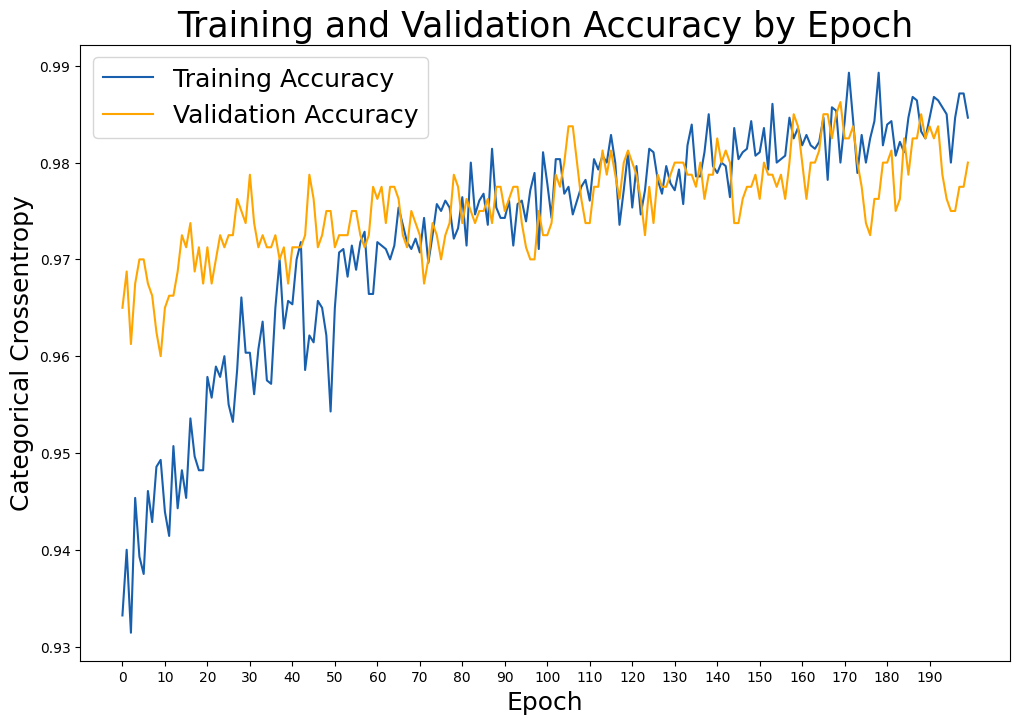

In [52]:
import matplotlib
import matplotlib.pyplot as plt
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,200,10), range(0,200,10))

plt.legend(fontsize = 18);

In [6]:
# We get our predictions from the test data
predict_x=model.predict(X_test) 
preds=np.argmax(predict_x,axis=1)

179/179 [==============================] - 0s 2ms/step


In [8]:
preds[2]

127

In [9]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
# We transform back our predictions to the speakers ids
preds = lb.inverse_transform(preds)

In [12]:
preds

array(['7113', '6181', '441', ..., '201', '8747', '6476'], dtype='<U4')

In [13]:
# We slice our dataframe to our test dataframe
df_test = df[trainSize+validationSize:]

In [14]:
# We create a new column called preds and set it equal to our predictions
df_test['preds'] = preds

/tmp/ipykernel_40327/593711799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['preds'] = preds


In [15]:
# Checking how our test dataframe looks like now with our predictions
df_test

,file,label,speaker,preds
51368,7113-86041-0068.flac,0,7113,7113
51369,6181-216552-0026.flac,1,6181,6181
51370,441-128988-0012.flac,0,441,441
51371,8838-298546-0004.flac,1,8838,8838
51372,7067-76048-0000.flac,1,7067,7067
...,...,...,...,...
57071,403-216-0008.flac,0,403,403
57072,3440-171009-0053.flac,0,3440,3440
57073,201-127786-0009.flac,1,201,201
57074,8747-293952-0062.flac,1,8747,8747


In [16]:
# Checking how many speakers we got wrong
df_test[df_test['speaker'] != df_test['preds']]

,file,label,speaker,preds
51874,2182-181173-0037.flac,0,2182,87
51991,8629-261139-0076.flac,1,8629,7226
52014,6147-34606-0000.flac,0,6147,19
52368,8629-261139-0076.flac,1,8629,7226
52959,5561-39621-0014.flac,0,5561,307
53533,5688-41232-0071.flac,0,5688,1183
53744,7367-86737-0061.flac,1,7367,8419
53757,89-219-0056.flac,0,89,7511
54493,5688-41232-0042.flac,0,5688,1183
55033,1737-142397-0014.flac,0,1737,125


In [17]:
# Checking our model accuracy
1-round(len(df_test[df_test['speaker'] != df_test['preds']])/len(df_test),5)

0.99685

#### 99.8% accurate on test data for classification of speakers

In [51]:
model.save("spktvrfiwithlabel")

2023-06-12 05:34:50.315883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,194]
	 [[{{node inputs}}]]
2023-06-12 05:34:50.327078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-06-12 05:34:50.339233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-06-12 05:34

INFO:tensorflow:Assets written to: spktvrfiwithlabel/assets


INFO:tensorflow:Assets written to: spktvrfiwithlabel/assets


In [1]:
import dill

In [2]:
dill.load_session('notebook_env.db')

2023-06-15 03:02:47.284497: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 03:02:47.346378: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 03:02:47.346982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 03:02:48.273168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-15 03:02:49.799688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

In [23]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_tests, y_pred_bool))

90/90 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        33
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        29
          13       1.00      1.00      1.00        26
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        24
          16       1.00     

In [22]:
y_tests

array([196, 173, 127, ...,  42, 242, 182])

In [5]:
df.to_csv('df.csv')

In [6]:
np.save('classes.npy', lb.classes_)

In [7]:
ss.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37',
       'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46',
       'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55',
       'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64',
       'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73',
       'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82',
       'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91',
       'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100',
       'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108',
       'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116',
       'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124',
       'x125

In [9]:
print("Scaler mean: ", ss.mean_)
print("Scaler scale: ", ss.scale_)

Scaler mean:  [-3.42636898e+02  1.14403900e+02 -2.52166704e+01  4.36561293e+01
 -7.91630303e+00  8.24034949e+00 -8.54223312e+00 -4.38943893e+00
 -3.54219944e+00 -4.65130734e+00  1.39754209e+00 -7.42011949e+00
  3.00970757e+00 -4.29678006e+00  2.51086606e+00 -3.33514949e+00
 -2.02270202e+00 -7.78887033e-02 -4.18190567e+00  1.06035705e-01
 -4.40086170e+00 -3.26814271e-01 -3.05620993e+00 -8.41757079e-01
 -1.16180725e+00 -1.23388536e+00  3.15398790e-01 -1.51579674e+00
  1.15811974e+00 -7.36353689e-01  7.62866566e-01  1.63402318e-01
  8.65366628e-01  7.91579007e-01  4.21844664e-01  1.26403804e+00
  2.46851775e-01  1.08985443e+00  1.80583230e-01  6.97547291e-01
  5.85768014e-01  5.77423491e-01  5.73321116e-01  5.76135191e-01
  5.84942008e-01  6.01566465e-01  6.14592842e-01  6.26003941e-01
  6.24717749e-01  6.08753662e-01  5.96474606e-01  5.93133259e-01
  1.35813672e+00  3.99174269e-01  1.27945299e+00  3.32301848e+00
  4.47958956e+00  4.41175222e+00  5.40222934e+00  6.43232339e+00
  5.7062032

In [67]:
from joblib import dump, load

In [68]:
dump(ss, 'std_scaler194.bin', compress=True)

['std_scaler194.bin']

In [73]:
dump(lb, 'labelEncoader.bin', compress=True)

['labelEncoader.bin']